In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from scipy.cluster.hierarchy import dendrogram, linkage
import joblib

In [2]:
# Load data from CSV
def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Data Loaded Successfully")
    print(df.head())
    return df


In [3]:
#To identify the most impactful features, we calculated the variance of each feature using the .var() function.
dataset1 = pd.read_csv('Mall_Customers.csv')
le = LabelEncoder()
dataset1['Genre'] = le.fit_transform(dataset1['Genre']) #Label encoding for Genre column -  Male = 1, Female =0
feature_variance = dataset1.var().sort_values(ascending=False)
print(feature_variance)

CustomerID                3350.000000
Annual Income (k$)         689.835578
Spending Score (1-100)     666.854271
Age                        195.133166
Genre                        0.247638
dtype: float64


In [4]:
# Preprocess data with label encoding and scaling
def preprocess_data(df):
    if 'Genre' in df.columns:
        label_encoder = LabelEncoder()
        df['Genre'] = label_encoder.fit_transform(df['Genre'])
        print("Genre column encoded successfully")

    # Drop 'CustomerID' column if it exists
    if 'CustomerID' in df.columns:
        df.drop('CustomerID', axis=1, inplace=True)
        print("CustomerID column dropped")
    
    # numeric_df = df.select_dtypes(include=[np.number]) # Selects all columns containing numeric data using data types. Returns a DataFrame with numeric columns only.
    # Calculate variance for all numeric columns
    feature_variance = df.var().sort_values(ascending=False)
    print("Feature Variance:\n", feature_variance)

    # Select the top 2 columns with the highest variance
    top_features = feature_variance.index[:2].tolist()
    print("Selected Features Based on Variance:", top_features)
    
    numeric_df = df[top_features].copy()

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    return numeric_df, scaled_data

In [5]:
# Elbow method for K-Means
def find_optimal_k(data):
    distortions = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

# Dendrogram for Hierarchical Clustering
def plot_dendrogram(data):
    linked = linkage(data, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

# Visualization for DBSCAN Clustering
def plot_dbscan(data, eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', edgecolors='k')
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

In [6]:
# Perform Clustering and Evaluate using appropriate metrics
algorithms = {
    'KMeans': {
        'model': KMeans(),
        'param_grid': {'n_clusters': range(3, 6), 'random_state': [42], 'init':['k-means++', 'random']},
        'metric': silhouette_score
    },
    'DBSCAN': {
        'model': DBSCAN(),
        'param_grid': {'eps': [0.3, 0.5, 0.7], 'min_samples': [5, 10]},
        'metric': davies_bouldin_score
    },
    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'param_grid': {'n_clusters': range(2, 6), 'linkage': ['ward', 'complete', 'average']},
        'metric': calinski_harabasz_score
    }
}

In [7]:
# Perform Clustering and Evaluate using appropriate metrics
def perform_clustering(df, data):
    results = {}
    best_models = {}
    
    for name, entry in algorithms.items():
        model_class = entry['model']
        metric = entry['metric']
        best_score = -np.inf
        best_labels = None
        best_model_name = None
        
        for params in ParameterGrid(entry['param_grid']):
            model = model_class.set_params(**params)
            labels = model.fit_predict(data)
            # print("Labelssss::",labels)
            
            if len(set(labels)) > 1:
                print("Labels count::",len(set(labels)))
                score = metric(data, labels)
                results[f'{name}_{params}'] = score # creates a dynamic key that combines name and param (results['KMeans_{\'n_clusters\': 10, \'param\': 5}'] = 0.5, which is "KMeans_{'n_clusters': 10, 'param': 5}": 0.5) 
                print(f"{name} with Params {params} - Score: {score}")

                if score > best_score:
                    best_score = score
                    best_labels = labels
                    best_model_name = params
            else:
                results[f'{name}_{params}'] = 'N/A'
                print(f"{name} with Params {params} - Invalid Clustering (Single Cluster Formed)")
        
        best_models[name] = {'BestParams': best_model_name, 'BestScore': best_score}
        print(f"\nBest Model for {name}: {best_model_name} with Score: {best_score}\n")
        
        # Update the dataframe with the cluster labels of the best model
        if best_labels is not None:
            df[f'{name}_Cluster'] = best_labels

    return results, df, best_models


In [8]:
# Save Results to Excel
def save_results_to_excel(results, df, results_path, data_path):
    results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Score'])
    results_df.to_excel(results_path, index=False)
    df.to_excel(data_path, index=False)
    print("Results saved to", results_path)
    print("Clustered Data saved to", data_path)

In [9]:
# # Visualize with Seaborn
# def visualize_clusters(df):
#     cluster_columns = [col for col in df.columns if 'Cluster' in col]

#     if not cluster_columns:
#         print("No cluster columns found. Ensure clustering was performed.")
#         return

#     for col in cluster_columns:
#         plt.figure(figsize=(8, 6))
#         sns.scatterplot(x=df.columns[0], y=df.columns[1], hue=col, palette='viridis', data=df)
#         plt.title(f'Cluster Visualization - {col}')
#         plt.legend(title=col)
#         plt.show()

In [10]:
# def save_best_model(best_model, model_name='unsupervised_best_model.pkl'):
#     joblib.dump(best_model, model_name)
#     print(f"Model saved successfully as {model_name}")


# def save_best_models(best_models):
   
#     for name, model_data in best_models.items():
#         model_filename = f'{name}_best_model.pkl'
#         joblib.dump(model_data['name'], model_filename)
#         print(f"Model saved as {model_filename}")

In [11]:
def save_best_models(best_models,data):
    for name, model_data in best_models.items():
        best_params = model_data['BestParams']
        print(f"Saving {name} with Params: {best_params}")

        # Initialize the model with best parameters
        if name == 'KMeans':
            model = KMeans(**best_params).fit(data)
        elif name == 'DBSCAN':
            model = DBSCAN(**best_params).fit(data)
        elif name == 'Agglomerative':
            model = AgglomerativeClustering(**best_params).fit(data)
        else:
            print(f"Unknown model: {name}")
            continue

        # Save the model to a .pkl file
        model_filename = f'{name}_best_model.pkl'
        joblib.dump(model, model_filename)
        print(f"Model saved as {model_filename}")

Data Loaded Successfully
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Genre column encoded successfully
CustomerID column dropped
Feature Variance:
 Annual Income (k$)        689.835578
Spending Score (1-100)    666.854271
Age                       195.133166
Genre                       0.247638
dtype: float64
Selected Features Based on Variance: ['Annual Income (k$)', 'Spending Score (1-100)']
Performing Elbow Method for K-Means...


C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

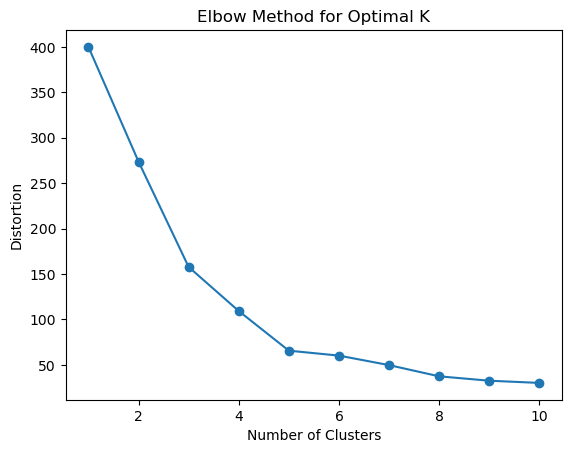

Generating Dendrogram for Hierarchical Clustering...


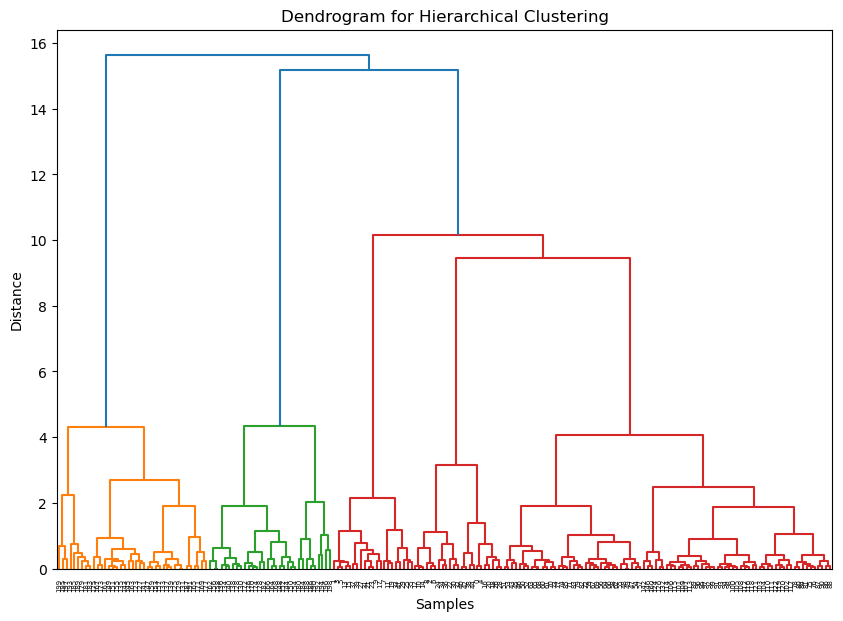

Performing DBSCAN Visualization...


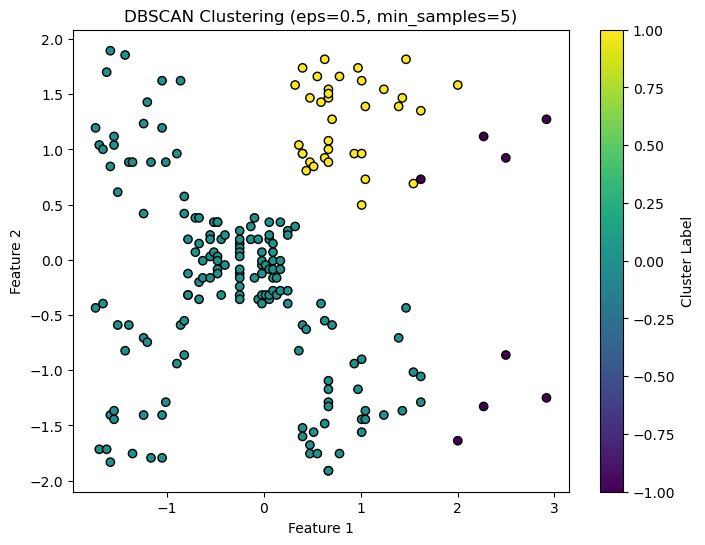

Performing Clustering and Evaluating...
Labels count:: 3
KMeans with Params {'init': 'k-means++', 'n_clusters': 3, 'random_state': 42} - Score: 0.46658474419000145
Labels count:: 4
KMeans with Params {'init': 'k-means++', 'n_clusters': 4, 'random_state': 42} - Score: 0.49434988482196784
Labels count:: 5
KMeans with Params {'init': 'k-means++', 'n_clusters': 5, 'random_state': 42} - Score: 0.5546571631111091
Labels count:: 3
KMeans with Params {'init': 'random', 'n_clusters': 3, 'random_state': 42} - Score: 0.46658474419000145


C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memor

Labels count:: 4
KMeans with Params {'init': 'random', 'n_clusters': 4, 'random_state': 42} - Score: 0.4939069237513199
Labels count:: 5
KMeans with Params {'init': 'random', 'n_clusters': 5, 'random_state': 42} - Score: 0.5546571631111091

Best Model for KMeans: {'init': 'k-means++', 'n_clusters': 5, 'random_state': 42} with Score: 0.5546571631111091

Labels count:: 8
DBSCAN with Params {'eps': 0.3, 'min_samples': 5} - Score: 2.025069803437564
Labels count:: 5
DBSCAN with Params {'eps': 0.3, 'min_samples': 10} - Score: 4.234195642737528
Labels count:: 3
DBSCAN with Params {'eps': 0.5, 'min_samples': 5} - Score: 0.8285103931757106
Labels count:: 5
DBSCAN with Params {'eps': 0.5, 'min_samples': 10} - Score: 1.9136847910184211
DBSCAN with Params {'eps': 0.7, 'min_samples': 5} - Invalid Clustering (Single Cluster Formed)
Labels count:: 2
DBSCAN with Params {'eps': 0.7, 'min_samples': 10} - Score: 0.8168269321334699

Best Model for DBSCAN: {'eps': 0.3, 'min_samples': 10} with Score: 4.2341

C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Results saved to clustering_results.xlsx
Clustered Data saved to clustered_data.xlsx
Deploying Best Model...
Params of Best_models :: {'KMeans': {'BestParams': {'init': 'k-means++', 'n_clusters': 5, 'random_state': 42}, 'BestScore': 0.5546571631111091}, 'DBSCAN': {'BestParams': {'eps': 0.3, 'min_samples': 10}, 'BestScore': 4.234195642737528}, 'Agglomerative': {'BestParams': {'linkage': 'complete', 'n_clusters': 5}, 'BestScore': 247.2082256100627}}
Saving KMeans with Params: {'init': 'k-means++', 'n_clusters': 5, 'random_state': 42}
Model saved as KMeans_best_model.pkl
Saving DBSCAN with Params: {'eps': 0.3, 'min_samples': 10}
Model saved as DBSCAN_best_model.pkl
Saving Agglomerative with Params: {'linkage': 'complete', 'n_clusters': 5}
Model saved as Agglomerative_best_model.pkl


C:\Users\Pavithira\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
# Main function
def main():
    file_path = 'Mall_Customers.csv'  # Input CSV file
    results_path = 'clustering_results.xlsx'
    data_path = 'clustered_data.xlsx'
    # algorithms_path = '/mnt/data/algorithms.json'

    df = load_data(file_path)
    df, data = preprocess_data(df)
    # algorithms = load_algorithms(algorithms_path)

    print("Performing Elbow Method for K-Means...")
    find_optimal_k(data)

    print("Generating Dendrogram for Hierarchical Clustering...")
    plot_dendrogram(data)

    print("Performing DBSCAN Visualization...")
    plot_dbscan(data)

    print("Performing Clustering and Evaluating...")
    results, df, best_models = perform_clustering(df, data)

    print("Saving Results to Excel...")
    save_results_to_excel(results, df, results_path, data_path)

    # print(df.head())
    # print(df['Cluster'].value_counts())    
    print("Deploying Best Model...")
    print("Params of Best_models ::",best_models)
    save_best_models(best_models,data)

if __name__ == '__main__':
    main()

Index(['Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')


<Figure size 600x600 with 0 Axes>

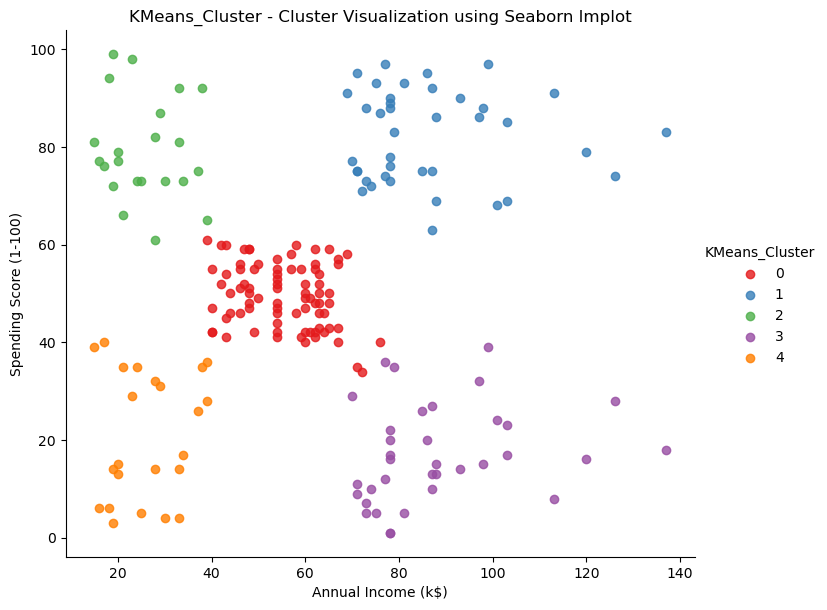

<Figure size 600x600 with 0 Axes>

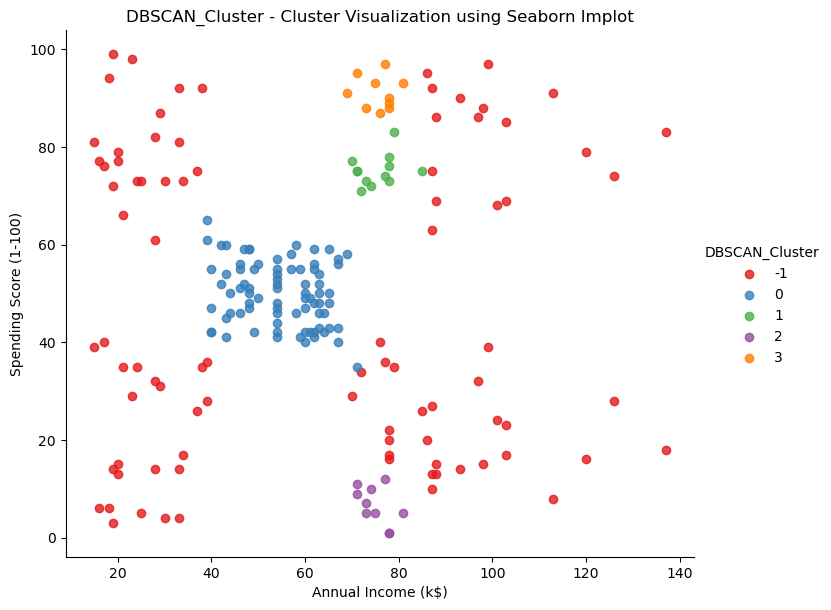

<Figure size 600x600 with 0 Axes>

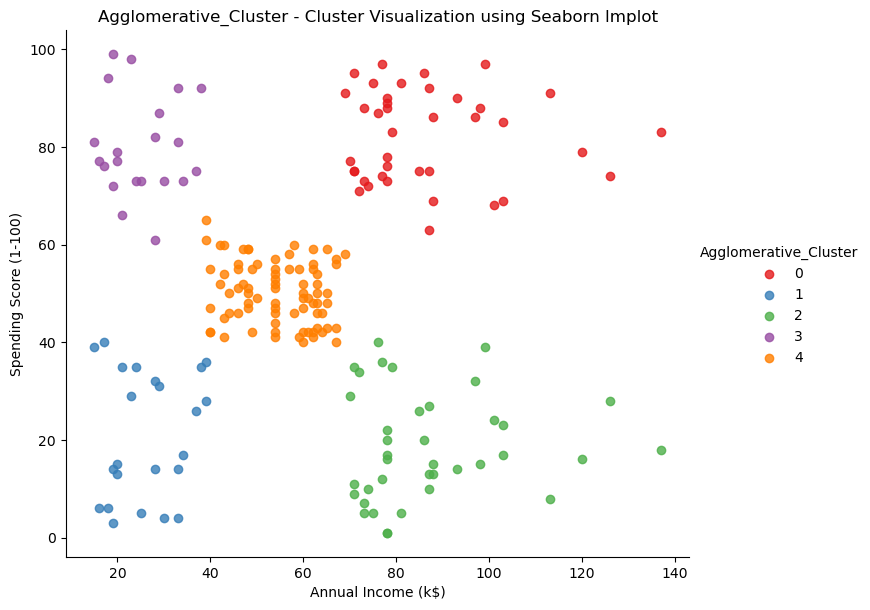

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_clusters_from_excel(file_path):
    # Load data from Excel
    df = pd.read_excel(file_path)
    
    # Identify the numeric columns excluding cluster columns
    cluster_columns = [col for col in df.columns if 'Cluster' in col]
    numeric_columns = df.select_dtypes(include='number').columns
    top_features = df[numeric_columns].var().sort_values(ascending=False).index[:2]
    print(top_features)

    # Plot for each clustering algorithm
    for cluster_col in cluster_columns:
        plt.figure(figsize=(6, 6))
        sns.lmplot(x=top_features[0], 
           y=top_features[1], 
           hue=cluster_col, 
           data=df, palette='Set1',
           fit_reg=False, 
           height=6, 
           aspect=1.2)

        plt.title(f'{cluster_col} - Cluster Visualization using Seaborn lmplot')
        plt.show()
        
# Example usage
plot_clusters_from_excel('clustered_data.xlsx')
